In [1]:
import pandas as pd
import os

In [2]:
## https://github.com/jms290/PolySyn_MSNs/blob/master/Data/AHBA/celltypes_PSP.csv
celltypes_df = 'D:\\OneDrive\\References\\PolySyn_MSNs-master\\Data\\AHBA\\celltypes_PSP.csv'

In [3]:
def generate_weight_filtered_csvs(input_csv_path, threshold=None, output_dir=None):

    # load the original data
    df = pd.read_csv(input_csv_path, header=None, names=["gene", "id", "weight"])

    # filter
    above_all = df[df["weight"].abs() > threshold]
    above_p = df[df["weight"] > threshold]
    above_n = df[df["weight"] < -threshold]

    base_name = os.path.splitext(os.path.basename(input_csv_path))[0]
    out_dir = output_dir if output_dir else os.path.dirname(input_csv_path)

    # form the output filename
    suffix = f"above{threshold}"
    all_path = os.path.join(out_dir, f"{base_name}_{suffix}_all.csv")
    p_path = os.path.join(out_dir, f"{base_name}_{suffix}_p.csv")
    n_path = os.path.join(out_dir, f"{base_name}_{suffix}_n.csv")

    # save the results
    above_all.to_csv(all_path, index=False, header=False)
    above_p.to_csv(p_path, index=False, header=False)
    above_n.to_csv(n_path, index=False, header=False)


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_overlap_bars(overlap_df,name_to_save=None):
    """
    Visualize the output from [count_gene_overlaps] as three horizontal bar plots.

    Parameters:
        overlap_df: Contains columns—celltype, overlap_with_all, overlap_with_p, overlap_with_n.
    """


    sns.set(style="whitegrid")
    plt.figure(figsize=(18, 6))

    overlap_types = ["overlap_with_all", "overlap_with_p", "overlap_with_n"]
    titles = ["|weight| > threshold", "weight > threshold", "weight < -threshold"]

    for i, (col, title) in enumerate(zip(overlap_types, titles)):
        plt.subplot(1, 3, i+1)
        sns.barplot(
            data=overlap_df.sort_values(col, ascending=True),
            x=col,
            y="celltype",
            palette='coolwarm'  
        )
        plt.title(title, fontsize=14)
        plt.xlabel("Number of overlapping genes", fontsize=12)
        plt.ylabel("Cell Type" if i == 0 else "", fontsize=12)

    plt.tight_layout()
    if name_to_save:
        plt.savefig(os.path.join(os.getcwd(), name_to_save + '.pdf'),dpi = 300)
    plt.show()

In [5]:
import pandas as pd
import numpy as np
from statsmodels.stats.multitest import multipletests

def permutation_test_overlap(celltypes_df, target_gene_set, n_permutations=10000, fdr_alpha=0.05, random_state=None):
    """
    Perform a permutation test for overlapping genes in each cell type, followed by FDR correction.

    Parameters：
        celltypes_df: Contains two columns — 'gene' and 'class'.
        target_gene_set: Target set of genes (e.g., genes with |weight| > 5).
        n_permutations: Number of permutations. Default is 10,000.
        fdr_alpha: Significance threshold for FDR correction. Default is 0.05.
        random_state: Random seed for reproducibility.

    Return：
        result_df: Contains the columns — celltype、observed_overlap、p_value、fdr_corrected_p and significant.
    """

    if random_state is not None:
        np.random.seed(random_state)

    # all the genes
    all_genes = set(celltypes_df["gene"].dropna())

    
    # gene sets for each cell type
    celltype_genes = celltypes_df.groupby("class")["gene"].apply(set)

    # observed overlap
    observed_counts = {
        celltype: len(genes & target_gene_set)
        for celltype, genes in celltype_genes.items()
    }

    p_values = []

    for celltype, genes in celltype_genes.items():
        gene_n = len(genes)
        null_counts = []

        for _ in range(n_permutations):
            sampled = set(np.random.choice(list(all_genes), size=gene_n, replace=False))
            overlap = len(sampled & target_gene_set)
            null_counts.append(overlap)

        null_counts = np.array(null_counts)
        obs = observed_counts[celltype]

        # one-sided (right-tailed) test 
        p = (np.sum(null_counts >= obs) + 1) / (n_permutations + 1)
        p_values.append(p)

    # FDR correction
    rejected, pvals_corrected, _, _ = multipletests(p_values, method="fdr_bh", alpha=fdr_alpha)

    # results
    result_df = pd.DataFrame({
        "celltype": list(celltype_genes.index),
        "observed_overlap": [observed_counts[c] for c in celltype_genes.index],
        "p_value": p_values,
        "fdr_corrected_p": pvals_corrected,
        "significant": rejected
    })

    return result_df


In [6]:
def count_gene_overlaps(celltypes_csv, all_csv, p_csv, n_csv,n_permutations=1000, fdr_alpha=0.05):
    """
    
    Count the number of overlapping genes between each cell type in cell types and three gene lists.

    Parameters:
        celltypes_csv: Path to the CSV file containing gene name and cell type columns.
        all_csv: Path to PLS1_geneWeights_above5_all.csv
        p_csv: Path to PLS1_geneWeights_above5_p.csv
        n_csv: Path to PLS1_geneWeights_above5_n.csv
    """

    celltypes_df = pd.read_csv(celltypes_csv)
    celltype_genes = celltypes_df.groupby("class")["gene"].apply(set)

    above_all = pd.read_csv(all_csv, header=None, names=["gene", "id", "weight"])
    above_p = pd.read_csv(p_csv, header=None, names=["gene", "id", "weight"])
    above_n = pd.read_csv(n_csv, header=None, names=["gene", "id", "weight"])

    set_all = set(above_all["gene"])
    set_p = set(above_p["gene"])
    set_n = set(above_n["gene"])

    # statistics
    overlap_results = []
    overlap_genes_p = []  
    for celltype, genes in celltype_genes.items():
        overlap_all = len(genes & set_all)
        overlap_p = len(genes & set_p)
        overlap_n = len(genes & set_n)
        overlap_results.append({
            "celltype": celltype,
            "overlap_with_all": overlap_all,
            "overlap_with_p": overlap_p,
            "overlap_with_n": overlap_n
        })
        
        overlap_genes_p.append({
            "celltype": celltype,
            "overlap_genes_with_p": list(genes & set_p)  
        })
        
    overlap_genes_p_df = pd.DataFrame(overlap_genes_p)
    overlap_genes_p_df.to_csv("overlap_genes_with_p.csv", index=False)
    
    # print the results
    overlap_df = pd.DataFrame(overlap_results)

    
    # significance test
    merged_df = overlap_df.copy()
    sets = {"all": set_all, "p": set_p, "n": set_n}
    for label, gene_set in sets.items():
        perm_df = permutation_test_overlap(celltypes_df, gene_set, n_permutations=n_permutations, fdr_alpha=fdr_alpha)

        perm_df = perm_df.rename(columns={
            "p_value": f"p_{label}",
            "fdr_corrected_p": f"fdr_p_{label}",
            "significant": f"sig_{label}",
            "observed_overlap": f"observed_overlap_{label}"  
        })

        merged_df = merged_df.merge(perm_df[["celltype", f"p_{label}", f"fdr_p_{label}", f"sig_{label}"]], on="celltype")
    
    return merged_df

✔️ 基于阈值 2 的三个CSV文件已保存至：
d:\OneDrive\GraduateStudent_Phd1\5_Addiction_multiscale_TMS\5_TMS_response\Epicenter\SC\dataHansenSSC\AHBA_TMS\PLS1_geneWeights_above2_all.csv
d:\OneDrive\GraduateStudent_Phd1\5_Addiction_multiscale_TMS\5_TMS_response\Epicenter\SC\dataHansenSSC\AHBA_TMS\PLS1_geneWeights_above2_p.csv
d:\OneDrive\GraduateStudent_Phd1\5_Addiction_multiscale_TMS\5_TMS_response\Epicenter\SC\dataHansenSSC\AHBA_TMS\PLS1_geneWeights_above2_n.csv
celltype  overlap_with_all  overlap_with_p  overlap_with_n    p_all  fdr_p_all  sig_all      p_p  fdr_p_p  sig_p      p_n  fdr_p_n  sig_n
   Astro               485             153             332 0.812188   1.000000    False 1.000000 1.000000  False 0.000999 0.001748   True
    Endo               532             331             201 0.346653   0.606643    False 0.000999 0.002331   True 1.000000 1.000000  False
   Micro               411             172             239 0.995005   1.000000    False 1.000000 1.000000  False 0.331668 0.464336  False

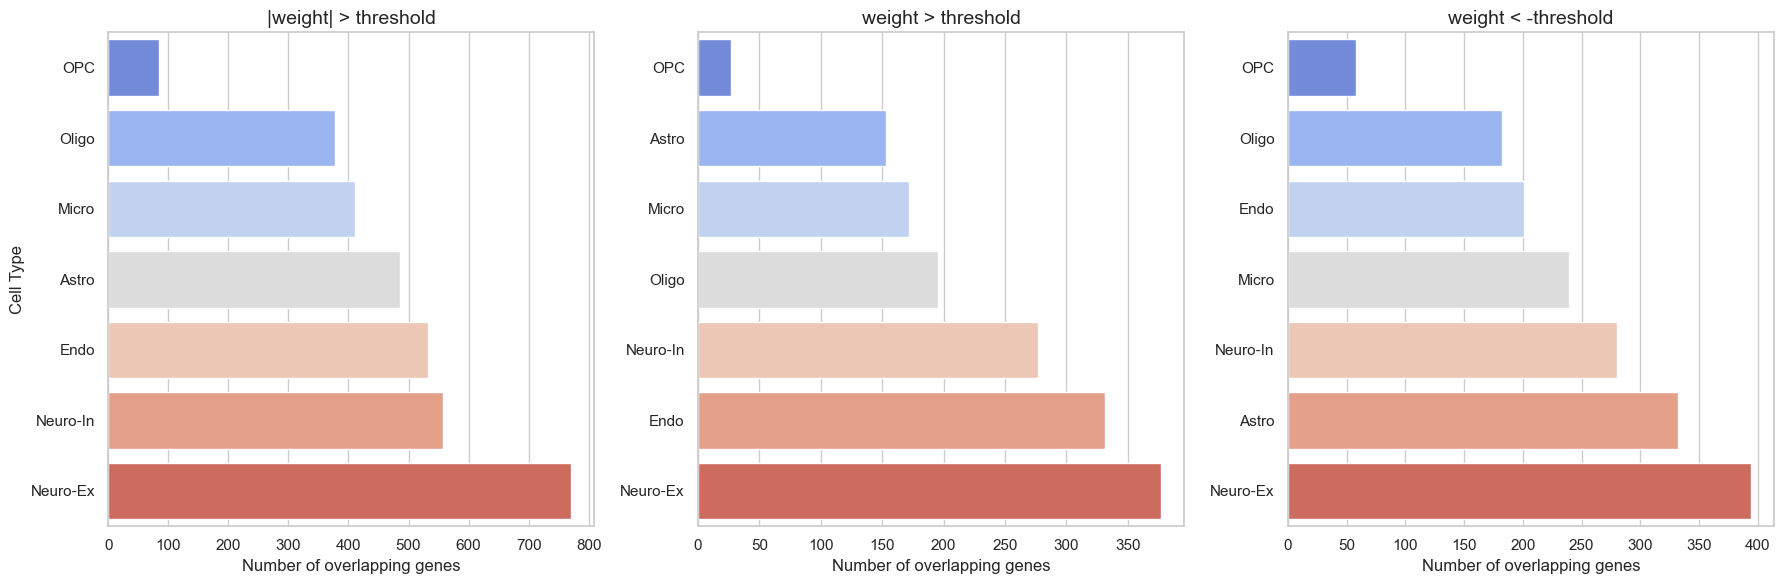

In [8]:
#th=2  ########## final threshold 250418
PLS1_geneWeights='D:\\OneDrive\\5_TMS_response\\Epicenter\\SC\\dataHansenSSC\\AHBA_TMS\\PLS1_geneWeights.csv'
wd='D:\\OneDrive\\5_TMS_response\\Epicenter\\SC\\dataHansenSSC\\AHBA_TMS\\'

th=2
generate_weight_filtered_csvs(PLS1_geneWeights, threshold=th, output_dir=os.getcwd())
all_csv = os.path.join(wd, f"PLS1_geneWeights_above{th}_all.csv")
p_csv=    os.path.join(wd, f"PLS1_geneWeights_above{th}_p.csv")
n_csv=    os.path.join(wd, f"PLS1_geneWeights_above{th}_n.csv")

overlap_df=count_gene_overlaps(celltypes_csv=celltypes_df,all_csv=all_csv,p_csv=p_csv,n_csv=n_csv)
print(overlap_df.to_string(index=False))
plot_overlap_bars(overlap_df,name_to_save='overlap_df_th2')